In [3]:
# Load packages
import os
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, normalize
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# borderlineSMOTE for oversampling
from imblearn import over_sampling

# extreme gradient boosting
import xgboost as xgb
from xgboost import XGBClassifier

# from sklearn.cluster import KMeans
# from scipy.cluster.vq import kmeans2

# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline

# Required for basic python plotting functionality
import matplotlib.pyplot as plt

# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
from tqdm import tqdm

# Advanced plotting functionality with seaborn
import seaborn as sns
#import folium  #needed for interactive map
#from folium.plugins import HeatMap
#from folium.plugins import FastMarkerCluster

sns.set(style="whitegrid")  # can set style depending on how you'd like it to look

# Importing dataset and other useful definitions

In [4]:
df = pd.read_csv('final_dataset_categoried.csv').drop(['Unnamed: 0'], axis=1)

In [5]:
df.head()

,Density,PercLatino,BachelorsRate,HousingUnits,TotalPop,Pop,PercAsian,PercBlack,MeanHHIncome,UnempRate,MedianHHIncome,AREA_WEIGHTED_RISK,PercWhite,ZipArea,count,minmax_count,minmax_content_amount,labels,totalContentsInsuranceCoverage,ZIP
0,6333.722287,0.152896,9100.0,18910,38876,37996,0.027832,0.131598,71218.0,0.043845,51132.0,0.646319,0.787221,5.999,897.695488,0.516220,0.554188,4,215159400.0,70001
1,5864.864865,0.170330,6504.0,9243,20748,18879,0.068874,0.127771,88894.0,0.063429,56786.0,0.513518,0.756940,3.219,1257.887442,0.723348,0.576048,4,212752400.0,70002
2,5720.188061,0.151738,9036.0,17085,41084,40150,0.041087,0.121945,74662.0,0.046281,58624.0,0.674042,0.801894,7.019,1174.139468,0.675189,0.766426,4,298825800.0,70003
3,5818.551279,0.111746,9197.0,12514,25200,24339,0.025437,0.027302,105106.0,0.040639,62982.0,0.585405,0.904881,4.183,1105.524743,0.635732,0.557463,4,235310300.0,70005
4,6065.276168,0.226628,4055.0,6536,16344,15703,0.059288,0.092450,86943.0,0.042713,63695.0,0.639270,0.794787,2.589,1738.979694,1.000000,0.500628,4,183343200.0,70006


In [6]:
final_columns=['Density',
   'MeanHHIncome',
   'BachelorsRate',
   'PercLatino',
   'HousingUnits',
   'TotalPop',
   'Pop',
   'PercAsian',
   'PercBlack',
   'UnempRate',
   'MedianHHIncome',
   'AREA_WEIGHTED_RISK',
   'PercWhite',
   'ZipArea']
targets = ['count', 'minmax_count', 'minmax_content_amount', 'labels', 'totalContentsInsuranceCoverage']

In [7]:
# display risk
def to_risk(risk):
    if risk == 0: return "low"
    if risk == 1: return "low-moderate"
    if risk == 2: return "moderate"
    if risk == 3: return "moderate-high"
    else: return "high"

In [8]:
X = df[final_columns]
y_count = df['count']
y_amount = df['totalContentsInsuranceCoverage']
y_minmax_count = df['minmax_count']
y_minmax_amount = df['minmax_content_amount']
y_labels = df['labels']

In [9]:
Counter(y_labels)

Counter({4: 50, 2: 66, 3: 17, 1: 133, 0: 205})

In [10]:
#model performances: adasyn < smote < svmsmote < borderlinesmote 
oversamp = over_sampling.BorderlineSMOTE()
X_res, y_res = oversamp.fit_resample(X, y_labels)
Counter(y_res)

Counter({4: 205, 2: 205, 3: 205, 1: 205, 0: 205})

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X_res, y_res)

In [12]:
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_labels)

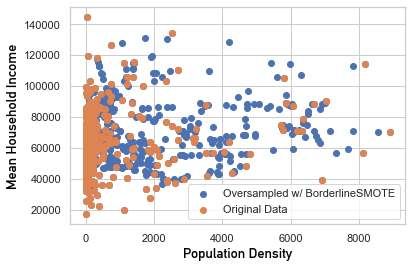

In [17]:
plt.figure()
font = {'family': 'DIN Alternate',
        'color':  'black',
        'weight': 'bold',
        'size': 14,
        }
plt.scatter(X_res['Density'], X_res['MeanHHIncome'], label='Oversampled w/ BorderlineSMOTE')
plt.scatter(df['Density'], df['MeanHHIncome'], label='Original Data')
plt.legend()
plt.xlabel('Population Density', fontdict=font)
plt.ylabel('Mean Household Income', fontdict=font)
plt.savefig('test.png', dpi=330, bbox_inches='tight')

# Clustering Algorithms (k-means, k-NN)

## k-nearest neighbors

In [29]:
k = 10 #K-nearest — hyperparameter
perf = dict()

for k in range(1, len(df) // 5):
    clf = neighbors.KNeighborsClassifier(k, weights='distance', algorithm='ball_tree') #'auto', 'ball_tree', 'kd_tree', 'brute'
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    report = classification_report(y_test, y_pred)
    perf[k] = [float(i) for i in report.split('\n')[-2].split()[2:5]]

In [30]:
ordered_knn_params = sorted(perf.items(), key=lambda r: 1 - r[1][0])
ordered_knn_params

[(4, [0.76, 0.76, 0.76]),
 (6, [0.76, 0.76, 0.76]),
 (1, [0.75, 0.75, 0.74]),
 (2, [0.75, 0.75, 0.74]),
 (3, [0.75, 0.76, 0.75]),
 (5, [0.75, 0.75, 0.75]),
 (7, [0.75, 0.76, 0.75]),
 (8, [0.74, 0.74, 0.74]),
 (11, [0.74, 0.74, 0.74]),
 (9, [0.73, 0.74, 0.73]),
 (10, [0.73, 0.74, 0.73]),
 (12, [0.73, 0.74, 0.73]),
 (14, [0.73, 0.73, 0.73]),
 (13, [0.72, 0.72, 0.72]),
 (15, [0.72, 0.72, 0.72]),
 (20, [0.72, 0.72, 0.71]),
 (22, [0.72, 0.72, 0.72]),
 (23, [0.72, 0.72, 0.71]),
 (28, [0.72, 0.72, 0.71]),
 (16, [0.71, 0.72, 0.71]),
 (17, [0.71, 0.72, 0.71]),
 (18, [0.71, 0.71, 0.7]),
 (19, [0.71, 0.71, 0.71]),
 (21, [0.71, 0.71, 0.71]),
 (24, [0.71, 0.71, 0.7]),
 (27, [0.71, 0.71, 0.71]),
 (29, [0.71, 0.71, 0.7]),
 (30, [0.71, 0.71, 0.7]),
 (35, [0.71, 0.7, 0.7]),
 (25, [0.7, 0.7, 0.7]),
 (26, [0.7, 0.7, 0.7]),
 (31, [0.7, 0.7, 0.7]),
 (32, [0.7, 0.7, 0.7]),
 (33, [0.7, 0.7, 0.69]),
 (34, [0.7, 0.7, 0.69]),
 (38, [0.7, 0.69, 0.69]),
 (39, [0.7, 0.69, 0.69]),
 (47, [0.7, 0.69, 0.69]),
 (48, [0

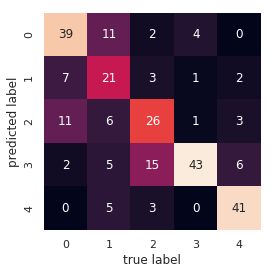

In [31]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(range(5)), yticklabels=list(range(5)))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [32]:
clf = neighbors.KNeighborsClassifier(29, weights='distance', algorithm='ball_tree') #'auto', 'ball_tree', 'kd_tree', 'brute'
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy score is {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.75      0.71      0.73        59
           1       0.65      0.50      0.56        48
           2       0.67      0.57      0.62        49
           3       0.66      0.90      0.76        49
           4       0.80      0.85      0.82        52

    accuracy                           0.71       257
   macro avg       0.70      0.71      0.70       257
weighted avg       0.71      0.71      0.70       257

Accuracy score is 0.708171206225681


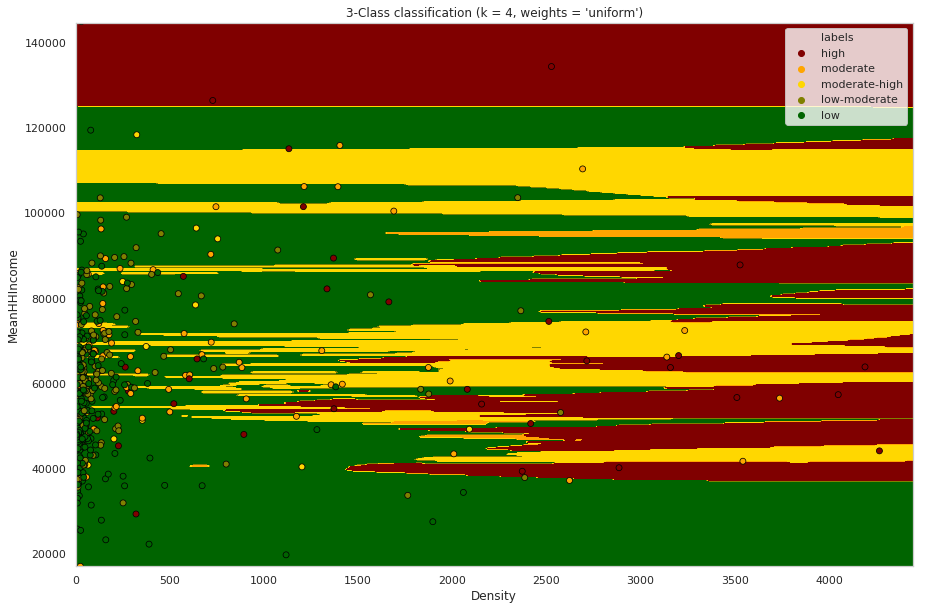

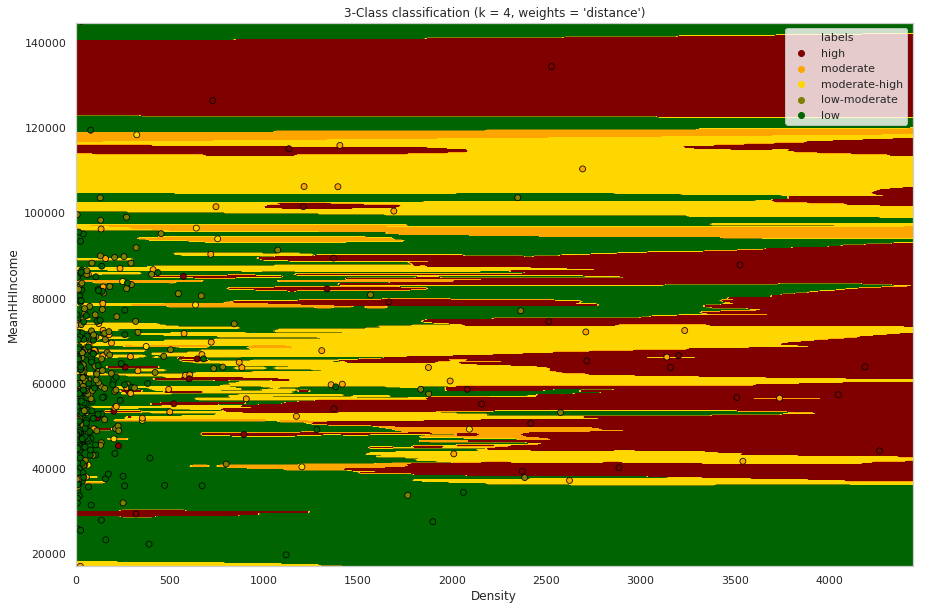

In [33]:
# seems that some k's works better than others. let's plot some results in 2D.
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
cmap_light = ListedColormap(['darkgreen', 'olive', 'gold', 'orange', 'maroon'])
cmap_bold = ['maroon', 'orange', 'gold', 'olive', 'darkgreen']#['green', 'lightgreen', 'yellow', 'coral', 'red']
weights = 'distance'
width = 500 #mesh step size
optimal_k = ordered_knn_params[0][0]

for weights in ['uniform', 'distance']:

    clf = neighbors.KNeighborsClassifier(optimal_k, weights=weights, algorithm='ball_tree') #'auto', 'ball_tree', 'kd_tree', 'brute'
    x_2d = X.values[:, :2]
    clf.fit(x_2d, y_labels)

    x_min, x_max = x_2d[:, 0].min() - 1, x_2d[:, 0].max() + 1
    y_min, y_max = x_2d[:, 1].min() - 1, x_2d[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min) / width),
                         np.arange(y_min, y_max, (y_max - y_min) / width))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(15, 10))
    try:
        plt.contourf(xx, yy, Z, cmap=cmap_light)
    except ValueError:
        pass

    # Plot also the training points
    sns.scatterplot(x=x_2d[:, 0], y=x_2d[:, 1], hue=y_labels.apply(to_risk),
                    palette=cmap_bold, alpha=1.0, edgecolor="black")
    plt.xlim(xx.min(), xx.max()/2)
    plt.ylim(yy.min(), yy.max())
    plt.title(f"3-Class classification (k = {optimal_k}, weights = '{weights}')")
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])

It's clear that we're losing a lot of information from using a uniform weighting (plurality vote system), so our optimal kNN approach can be shown using density.

# Logistic Regression

In [34]:
model = make_pipeline(MinMaxScaler(), LogisticRegression())
model.fit(x_train, y_train)
logreg_pred = model.predict(x_test)
print(classification_report(y_test, logreg_pred))
print(f"Accuracy score is {accuracy_score(y_test, logreg_pred)}")

              precision    recall  f1-score   support

           0       0.76      0.75      0.75        59
           1       0.61      0.46      0.52        48
           2       0.65      0.53      0.58        49
           3       0.60      0.82      0.69        49
           4       0.80      0.87      0.83        52

    accuracy                           0.69       257
   macro avg       0.68      0.68      0.68       257
weighted avg       0.69      0.69      0.68       257

Accuracy score is 0.688715953307393


# Naive Bayes

In [25]:
model = make_pipeline(QuantileTransformer(), MultinomialNB())
model.fit(x_train, y_train)
y_pred_nb = model.predict(x_test)
print(classification_report(y_test, y_pred_nb))
print(f"Accuracy score is {accuracy_score(y_test, y_pred_nb)}")

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        51
           1       0.48      0.47      0.48        51
           2       0.48      0.43      0.45        49
           3       0.59      0.57      0.58        51
           4       0.75      0.80      0.77        55

    accuracy                           0.61       257
   macro avg       0.60      0.60      0.60       257
weighted avg       0.60      0.61      0.60       257

Accuracy score is 0.6070038910505836


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2615: UserWarning: n_quantiles (1000) is greater than the total number of samples (768). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


# Artificial Neural Nets (ANN)

In [ ]:
t100 = []
max_pred = None
maxt = None
maxv = -12312312312
for i in tqdm(range(1, 100, 10)):
    for j in tqdm(range(1, 100, 10)):
        for k in range(1, 100, 10):
            for l in range(1, 100, 10):
                clf = make_pipeline(MinMaxScaler(), MLPClassifier(solver='adam', activation='relu', alpha=1e-5, learning_rate='constant',
                    hidden_layer_sizes=(i, j, k, l ), warm_start=False, random_state=1, max_iter=1000))
                clf.fit(x_train.values, y_train.values)
                y_pred_nn = clf.predict(x_test.values)
                t100.append((accuracy_score(y_test, y_pred_nn), (i, j, k, l)))
                t100 = sorted(t100)[:100]
#print(classification_report(y_test, max_pred))
#print(f"Accuracy score is {accuracy_score(y_test, max_pred)}")

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")

 10%|█         | 1/10 [00:28<04:20, 28.91s/it]/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")

 20%|██        | 2/10 [00:57<03:49, 28.63s/it]

In [18]:
#import runs from Colab sessions:
# low numbers of nodes, 3 hidden layers
low_nodes = pd.read_csv('upper_sweep_symmetric_non_overfitted.csv')\
    .drop(['Unnamed: 0'], axis=1).sort_values(by="0", ascending=False)
low_nodes.columns = ['accuracy', 'structure']
high_nodes1 = pd.read_csv('upper_sweep-2.csv').drop(['Unnamed: 0'], axis=1)\
    .sort_values(by="0", ascending=False).iloc[:50]
high_nodes2 = pd.read_csv('upper_sweep.csv').drop(['Unnamed: 0'], axis=1)\
    .sort_values(by="0", ascending=False).iloc[:50]
# high numbers of nodes, 4 hidden layers
high_nodes = high_nodes2.append(high_nodes1).reset_index().drop(columns=['index'])\
    .sort_values(by="0", ascending=False)
high_nodes.columns = ['accuracy', 'structure']
combined_nodes = high_nodes.append(low_nodes).reset_index().drop(columns=['index'])

In [19]:
combined_nodes['structure'] = combined_nodes['structure'].apply(lambda test_str: tuple(map(int, test_str[1:-1].split(', '))))

From experimentation with more layers and more nodes, we see that anything more than 5 layers tends to overfit dramatically. As a result, we'll try hidden layer structures in high_nodes, but nothing more. We turn to CNNs to help solve that problem.

In [20]:
clf = make_pipeline(MinMaxScaler(), MLPClassifier(solver='adam', activation='relu', alpha=1e-5, learning_rate='constant',
                hidden_layer_sizes=(81, 71, 91), warm_start=False, random_state=1, max_iter=1000))
clf.fit(x_train.values, y_train.values)
y_pred_nn = clf.predict(x_test.values)
print(classification_report(y_test, y_pred_nn))
print(f"Accuracy score is {accuracy_score(y_test, y_pred_nn)}")

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        53
           1       0.62      0.48      0.54        44
           2       0.71      0.83      0.77        48
           3       0.91      0.95      0.93        56
           4       0.89      0.89      0.89        56

    accuracy                           0.79       257
   macro avg       0.78      0.78      0.78       257
weighted avg       0.79      0.79      0.79       257

Accuracy score is 0.7937743190661478


In [22]:
# draft export for datafolio
for_display = pd.DataFrame()
for_display['zipcode'] = df['ZIP']
for_display['correct_risk'] = y_labels
for_display['predicted_risk'] = clf.predict(X)
#5 is the best score — spot on, 0 is the worst, completely wrong.
for_display['accuracy_score'] = 5 - abs(for_display['correct_risk'] - for_display['predicted_risk'])
print(classification_report(for_display['correct_risk'], for_display['predicted_risk']))
print(f"Accuracy score is {accuracy_score(for_display['correct_risk'], for_display['predicted_risk'])}")
for_display.to_csv('ann_display_data.csv')

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       205
           1       0.86      0.83      0.84       133
           2       0.81      0.89      0.85        66
           3       0.72      0.76      0.74        17
           4       0.92      0.92      0.92        50

    accuracy                           0.88       471
   macro avg       0.85      0.86      0.85       471
weighted avg       0.88      0.88      0.88       471

Accuracy score is 0.881104033970276


# Convolutional Neural Net Outline (Further Works)

In [ ]:
scaler = MinMaxScaler()
x_train_reshaped = scaler.fit_transform(x_train)
x_test_reshaped = scaler.transform(x_test)
x_train_reshaped = x_train_reshaped.reshape(-1, 768, 14, 1)
x_test_reshaped = x_test_reshaped.reshape(-1, 257, 14, 1)
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [ ]:
x_train_reshaped.shape

In [23]:
# from a previous images example—need to find a mapping from 1x14 to an image.
batch_size = 64
epochs = 20
num_classes = 5
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))

NameError: name 'Sequential' is not defined

# Random Forest Classifier

In [13]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
mat = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
score = accuracy_score(y_test, y_pred)
print("Accuracy score is", score)

              precision    recall  f1-score   support

           0       0.54      0.79      0.64        53
           1       0.32      0.23      0.27        44
           2       0.00      0.00      0.00        48
           3       0.57      0.86      0.69        56
           4       0.73      0.84      0.78        56

    accuracy                           0.57       257
   macro avg       0.43      0.54      0.48       257
weighted avg       0.45      0.57      0.50       257

Accuracy score is 0.5719844357976653


/Users/Sathya/anaconda3/envs/pyrecent/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


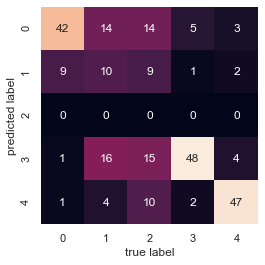

In [14]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(range(5)), yticklabels=list(range(5)))
plt.xlabel('true label')
plt.ylabel('predicted label');

# XGBoost Algorithm

In [15]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mat = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
score = accuracy_score(y_test, y_pred)
print("Accuracy score is", score)

/Users/Sathya/anaconda3/envs/pyrecent/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.78      0.75      0.77        53
           1       0.68      0.64      0.66        44
           2       0.74      0.81      0.77        48
           3       0.95      0.93      0.94        56
           4       0.89      0.91      0.90        56

    accuracy                           0.82       257
   macro avg       0.81      0.81      0.81       257
weighted avg       0.82      0.82      0.82       257

Accuracy score is 0.8171206225680934


Text(89.18, 0.5, 'predicted label')

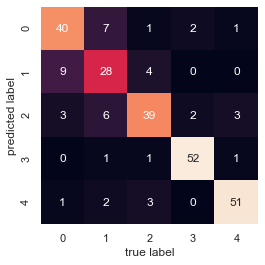

In [16]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(range(5)), yticklabels=list(range(5)))
plt.xlabel('true label')
plt.ylabel('predicted label')

In [17]:
#generating prediction column for data visualization

for_display = pd.DataFrame()
for_display['zipcode'] = df['ZIP'] # original final_dataset_categorized.csv's ZIP column 
for_display['correct_risk'] = y_labels
for_display['predicted_risk'] = model.predict(X)

#5 is the best score — spot on, 0 is the worst, completely wrong.
for_display['accuracy_score'] = 5 - abs(for_display['correct_risk'] - for_display['predicted_risk'])
print(classification_report(for_display['correct_risk'], for_display['predicted_risk']))
print(f"Accuracy score is {accuracy_score(for_display['correct_risk'], for_display['predicted_risk'])}")
for_display.to_csv('xgboost_display_data.csv')

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       205
           1       0.88      0.94      0.91       133
           2       0.94      0.92      0.93        66
           3       0.86      0.71      0.77        17
           4       0.96      0.88      0.92        50

    accuracy                           0.92       471
   macro avg       0.91      0.88      0.89       471
weighted avg       0.92      0.92      0.92       471

Accuracy score is 0.9171974522292994
